In [1]:
import torch
import spectral_chisel

In [2]:
n = m = 4096
mat = torch.normal(0, 1, (n, m)).cuda()

(array([52., 54., 52., 51., 51., 54., 52., 51., 52., 51., 52., 51., 51.,
        53., 52., 49., 53., 51., 50., 52., 50., 51., 51., 51., 49., 52.,
        50., 49., 50., 51., 49., 48., 49., 49., 51., 50., 47., 48., 48.,
        47., 47., 47., 49., 46., 46., 46., 48., 45., 47., 44., 45., 43.,
        46., 44., 43., 43., 42., 43., 43., 42., 43., 39., 42., 40., 39.,
        39., 39., 39., 38., 38., 36., 37., 36., 35., 35., 35., 33., 31.,
        33., 32., 31., 31., 30., 30., 26., 28., 26., 26., 24., 24., 22.,
        22., 20., 19., 16., 17., 13., 11., 10.,  8.]),
 array([1.19463615e-02, 1.28887200e+00, 2.56579757e+00, 3.84272313e+00,
        5.11964893e+00, 6.39657450e+00, 7.67350006e+00, 8.95042515e+00,
        1.02273512e+01, 1.15042763e+01, 1.27812023e+01, 1.40581284e+01,
        1.53350534e+01, 1.66119785e+01, 1.78889046e+01, 1.91658306e+01,
        2.04427567e+01, 2.17196808e+01, 2.29966068e+01, 2.42735329e+01,
        2.55504589e+01, 2.68273830e+01, 2.81043091e+01, 2.93812351e+01,
  

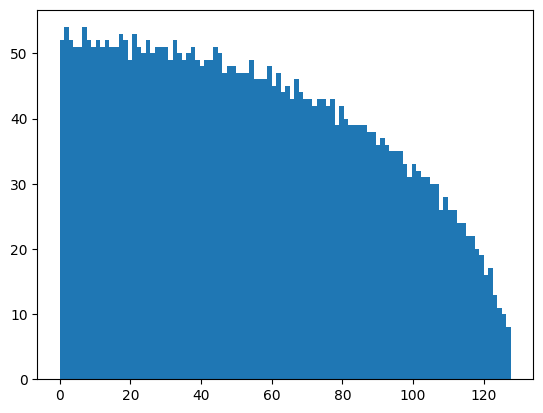

In [3]:
import matplotlib.pyplot as plt

with torch.no_grad():
    s = torch.linalg.svdvals(mat)

# Marchenko-Pastur distribution for large n, m:
# https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution
plt.hist(s.cpu(), bins=100)

(array([ 42.,  41.,  41.,  40.,  40.,  42.,  40.,  41.,  41.,  39.,  42.,
         40.,  39.,  42.,  39.,  41.,  40.,  42.,  40.,  40.,  41.,  41.,
         38.,  40.,  41.,  39.,  40.,  40.,  39.,  39.,  40.,  40.,  38.,
         41.,  39.,  39.,  37.,  40.,  40.,  39.,  38.,  38.,  38.,  40.,
         39.,  38.,  37.,  38.,  37.,  37.,  39.,  35.,  38.,  36.,  38.,
         37.,  37.,  36.,  35.,  38.,  35.,  37.,  34.,  36.,  35.,  35.,
         34.,  36.,  34.,  35.,  31.,  35.,  35.,  31.,  34.,  33.,  34.,
         31.,  33.,  33.,  32.,  30.,  31.,  30.,  31.,  30.,  32.,  28.,
         29.,  29.,  30.,  30.,  27.,  27.,  28.,  26.,  28.,  25.,  26.,
        514.]),
 array([1.19463615e-02, 1.01182687e+00, 2.01170754e+00, 3.01158786e+00,
        4.01146841e+00, 5.01134920e+00, 6.01122952e+00, 7.01111031e+00,
        8.01099110e+00, 9.01087093e+00, 1.00107517e+01, 1.10106325e+01,
        1.20105124e+01, 1.30103931e+01, 1.40102739e+01, 1.50101547e+01,
        1.60100346e+01, 1.7009

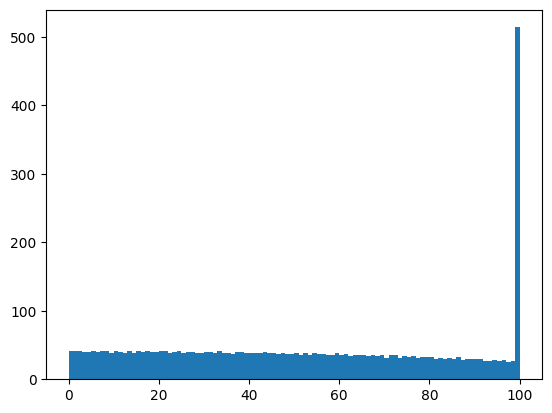

In [4]:
with torch.no_grad():
    U, S, Vh = torch.linalg.svd(mat)
    S_capped = torch.clamp(S, max=100)
    mat_capped = U @ torch.diag(S_capped) @ Vh

plt.hist(S_capped.cpu(), bins=100)

(array([44., 45., 43., 45., 41., 43., 46., 41., 44., 44., 44., 43., 43.,
        42., 44., 44., 43., 43., 43., 45., 42., 43., 43., 43., 40., 44.,
        41., 43., 42., 42., 43., 42., 43., 42., 40., 43., 41., 41., 41.,
        40., 42., 43., 40., 41., 41., 39., 40., 41., 37., 41., 40., 39.,
        39., 39., 40., 37., 38., 40., 36., 38., 39., 37., 38., 36., 37.,
        37., 35., 35., 36., 37., 35., 35., 33., 36., 34., 42., 49., 51.,
        57., 58., 59., 59., 59., 61., 59., 63., 59., 55., 47., 40., 37.,
        34., 31., 29., 26., 22., 20., 18., 12.,  9.]),
 array([1.19428374e-02, 1.08199060e+00, 2.15203834e+00, 3.22208619e+00,
        4.29213428e+00, 5.36218166e+00, 6.43222952e+00, 7.50227737e+00,
        8.57232571e+00, 9.64237309e+00, 1.07124205e+01, 1.17824688e+01,
        1.28525162e+01, 1.39225645e+01, 1.49926119e+01, 1.60626602e+01,
        1.71327076e+01, 1.82027550e+01, 1.92728043e+01, 2.03428516e+01,
        2.14128990e+01, 2.24829464e+01, 2.35529938e+01, 2.46230431e+01,
  

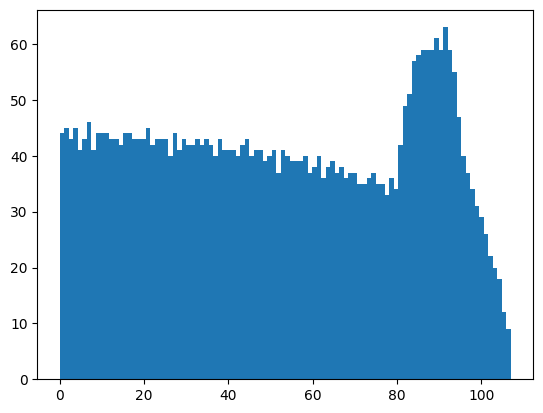

In [5]:
with torch.no_grad():
    shaved = torch.clone(mat)
    sc = spectral_chisel.SpectralChisel(shaved)
    sc.shave(shaved, s_max=100, steps=n)
    s_shaved = torch.linalg.svdvals(shaved)

plt.hist(s_shaved.cpu(), bins=100)

(array([42., 41., 41., 40., 41., 41., 40., 42., 40., 39., 42., 40., 39.,
        42., 40., 41., 40., 42., 39., 41., 41., 41., 39., 40., 41., 39.,
        38., 41., 40., 40., 38., 40., 39., 41., 39., 38., 39., 39., 39.,
        40., 39., 38., 39., 39., 39., 38., 38., 37., 38., 36., 38., 36.,
        37., 38., 38., 36., 37., 37., 34., 38., 34., 38., 33., 36., 36.,
        35., 35., 35., 34., 36., 31., 32., 36., 32., 35., 33., 33., 31.,
        34., 32., 31., 32., 31., 30., 30., 32., 30., 29., 30., 28., 71.,
        77., 79., 79., 78., 77., 78., 79., 76., 63.]),
 array([1.19454591e-02, 1.01328981e+00, 2.01463413e+00, 3.01597834e+00,
        4.01732254e+00, 5.01866722e+00, 6.02001143e+00, 7.02135563e+00,
        8.02270031e+00, 9.02404404e+00, 1.00253887e+01, 1.10267334e+01,
        1.20280771e+01, 1.30294218e+01, 1.40307655e+01, 1.50321102e+01,
        1.60334549e+01, 1.70347996e+01, 1.80361423e+01, 1.90374870e+01,
        2.00388317e+01, 2.10401764e+01, 2.20415211e+01, 2.30428658e+01,
  

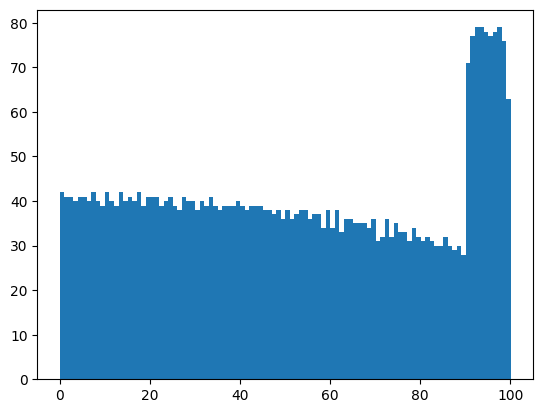

In [6]:
with torch.no_grad():
    shaved = torch.clone(mat)
    sc = spectral_chisel.SpectralChisel(shaved)
    sc.shave(shaved, s_max=100, steps=n, iter_per_step=5)
    s_shaved = torch.linalg.svdvals(shaved)

plt.hist(s_shaved.cpu(), bins=100)

(array([ 42.,  41.,  41.,  40.,  40.,  42.,  40.,  41.,  41.,  39.,  42.,
         40.,  39.,  42.,  39.,  42.,  40.,  41.,  40.,  40.,  42.,  40.,
         38.,  40.,  42.,  39.,  39.,  40.,  39.,  40.,  40.,  40.,  38.,
         41.,  38.,  39.,  39.,  39.,  39.,  39.,  38.,  38.,  39.,  39.,
         40.,  37.,  38.,  37.,  38.,  37.,  38.,  35.,  39.,  36.,  37.,
         37.,  37.,  37.,  35.,  38.,  34.,  37.,  34.,  36.,  35.,  36.,
         33.,  36.,  34.,  35.,  31.,  35.,  35.,  32.,  33.,  34.,  34.,
         30.,  35.,  32.,  31.,  30.,  31.,  31.,  31.,  30.,  32.,  27.,
         30.,  29.,  30.,  30.,  27.,  28.,  30., 152., 126., 114., 112.,
        111.]),
 array([1.19478032e-02, 1.01209235e+00, 2.01223683e+00, 3.01238132e+00,
        4.01252604e+00, 5.01267052e+00, 6.01281500e+00, 7.01295948e+00,
        8.01310349e+00, 9.01324844e+00, 1.00133924e+01, 1.10135374e+01,
        1.20136814e+01, 1.30138264e+01, 1.40139704e+01, 1.50141153e+01,
        1.60142593e+01, 1.7014

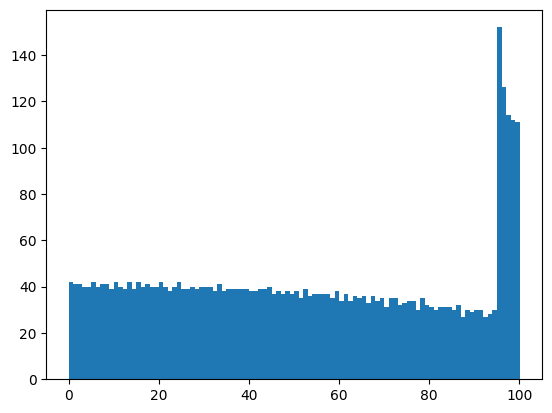

In [7]:
with torch.no_grad():
    shaved = torch.clone(mat)
    sc = spectral_chisel.SpectralChisel(shaved)
    sc.shave(shaved, s_max=100, steps=n, iter_per_step=10)
    s_shaved = torch.linalg.svdvals(shaved)

plt.hist(s_shaved.cpu(), bins=100)

(array([ 42.,  41.,  41.,  40.,  40.,  42.,  40.,  42.,  40.,  39.,  42.,
         40.,  39.,  42.,  40.,  41.,  40.,  41.,  40.,  41.,  41.,  40.,
         39.,  40.,  41.,  39.,  39.,  40.,  39.,  41.,  39.,  40.,  38.,
         41.,  38.,  40.,  38.,  39.,  39.,  40.,  38.,  38.,  38.,  40.,
         39.,  38.,  38.,  37.,  37.,  38.,  38.,  35.,  39.,  37.,  36.,
         38.,  36.,  36.,  36.,  38.,  35.,  36.,  34.,  36.,  35.,  35.,
         35.,  35.,  34.,  34.,  33.,  34.,  34.,  32.,  34.,  33.,  34.,
         32.,  33.,  32.,  31.,  32.,  30.,  31.,  31.,  30.,  31.,  29.,
         29.,  29.,  31.,  28.,  28.,  28.,  26.,  26.,  29., 102., 184.,
        277.]),
 array([1.19487401e-02, 1.01248419e+00, 2.01301980e+00, 3.01355529e+00,
        4.01409054e+00, 5.01462603e+00, 6.01516151e+00, 7.01569700e+00,
        8.01623249e+00, 9.01676846e+00, 1.00173035e+01, 1.10178394e+01,
        1.20183744e+01, 1.30189104e+01, 1.40194454e+01, 1.50199814e+01,
        1.60205173e+01, 1.7021

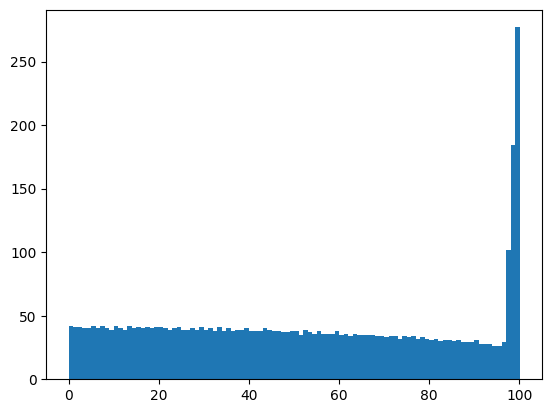

In [8]:
with torch.no_grad():
    shaved = torch.clone(mat)
    sc = spectral_chisel.SpectralChisel(shaved)
    sc.shave(shaved, s_max=100, steps=n, iter_per_step=20)
    s_shaved = torch.linalg.svdvals(shaved)

plt.hist(s_shaved.cpu(), bins=100)

(array([52., 54., 52., 51., 51., 53., 52., 52., 52., 50., 52., 52., 51.,
        53., 52., 49., 53., 51., 50., 52., 50., 50., 52., 50., 50., 51.,
        50., 49., 50., 51., 48., 49., 50., 48., 51., 49., 48., 48., 47.,
        48., 46., 48., 48., 47., 46., 46., 47., 45., 46., 45., 45., 44.,
        46., 43., 44., 42., 43., 42., 44., 41., 42., 41., 41., 41., 39.,
        38., 39., 40., 38., 37., 39., 37., 35., 35., 34., 35., 32., 33.,
        32., 32., 31., 31., 31., 29., 26., 28., 26., 26., 25., 23., 22.,
        23., 19., 18., 18., 16., 14., 12., 10.,  7.]),
 array([1.19498102e-02, 1.28804755e+00, 2.56414509e+00, 3.84024286e+00,
        5.11634064e+00, 6.39243841e+00, 7.66853619e+00, 8.94463348e+00,
        1.02207317e+01, 1.14968290e+01, 1.27729263e+01, 1.40490246e+01,
        1.53251219e+01, 1.66012192e+01, 1.78773174e+01, 1.91534157e+01,
        2.04295120e+01, 2.17056103e+01, 2.29817085e+01, 2.42578068e+01,
        2.55339031e+01, 2.68100014e+01, 2.80860996e+01, 2.93621960e+01,
  

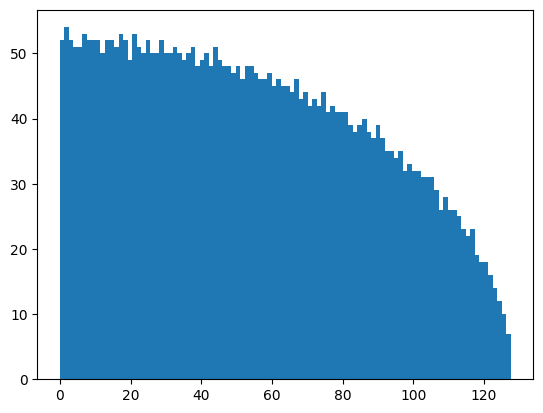

In [9]:
with torch.no_grad():
    decayed = torch.clone(mat)
    sc = spectral_chisel.SpectralChisel(decayed)
    sc.weight_decay(decayed, wd=0.1, s_max=100)
    s_decayed = torch.linalg.svdvals(decayed)

plt.hist(s_decayed.cpu(), bins=100)

(array([43., 42., 43., 41., 40., 42., 42., 41., 42., 43., 41., 41., 40.,
        43., 40., 42., 42., 41., 41., 41., 42., 42., 41., 41., 41., 39.,
        41., 42., 39., 41., 40., 41., 40., 41., 40., 40., 38., 43., 39.,
        39., 38., 41., 40., 39., 39., 39., 39., 38., 38., 38., 39., 37.,
        38., 38., 37., 39., 35., 37., 37., 37., 36., 36., 37., 35., 37.,
        37., 33., 36., 35., 34., 34., 34., 34., 35., 33., 33., 33., 34.,
        32., 32., 32., 31., 31., 33., 31., 29., 43., 65., 70., 73., 73.,
        77., 69., 76., 67., 59., 52., 42., 33., 16.]),
 array([1.19525511e-02, 1.03653538e+00, 2.06111813e+00, 3.08570099e+00,
        4.11028385e+00, 5.13486624e+00, 6.15944910e+00, 7.18403196e+00,
        8.20861435e+00, 9.23319721e+00, 1.02577801e+01, 1.12823629e+01,
        1.23069458e+01, 1.33315287e+01, 1.43561115e+01, 1.53806944e+01,
        1.64052773e+01, 1.74298592e+01, 1.84544430e+01, 1.94790249e+01,
        2.05036087e+01, 2.15281906e+01, 2.25527744e+01, 2.35773563e+01,
  

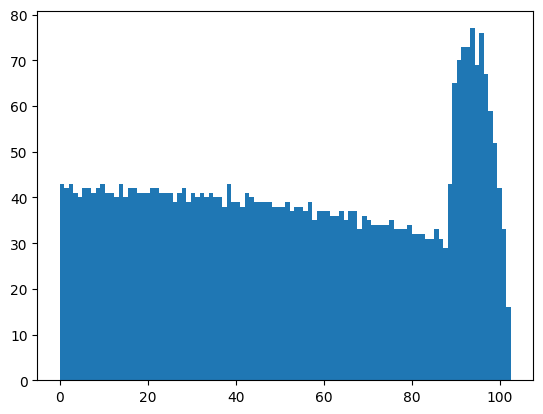

In [10]:
with torch.no_grad():
    decayed = torch.clone(mat)
    sc = spectral_chisel.SpectralChisel(decayed)
    sc.weight_decay(decayed, wd=0.1, s_max=100, iter_per_step=20)
    s_decayed = torch.linalg.svdvals(decayed)

plt.hist(s_decayed.cpu(), bins=100)